In [1]:
import os
print(os.getcwd())

/home/gungarg/Data/Affine/Code


In [2]:
!pip freeze | grep Keras

Keras==2.2.4
Keras-Applications==1.0.6
Keras-Preprocessing==1.0.5


In [3]:
import sys
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras import callbacks
import time
#from resnext1 import *
from keras.applications.resnet50 import ResNet50
import h5py
start = time.time()
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import glob
import cv2
%matplotlib inline

Using TensorFlow backend.


In [4]:
DEV = False
argvs = sys.argv
argc = len(argvs)


if argc > 1 and (argvs[1] == "--development" or argvs[1] == "-d"):
  DEV = True
if DEV:
  epochs = 2
else:
  epochs = 100

train_data_path = '/home/gungarg/Data/Affine/Severe_Accidents/train'
validation_data_path = '/home/gungarg/Data/Affine/Severe_Accidents/val'
test_data_path = '/home/gungarg/Data/Affine/Severe_Accidents/test'

In [5]:
data = pd.read_csv('/home/gungarg/Data/Affine/Severe_Accidents/Data_Annotation.csv')

In [6]:
from keras import backend as K

num_classes_2 = 12
num_classes_3 = 2
num_classes_4 = 6
num_classes_5 = 6
num_classes_6 = 2
num_classes_7 = 9
tot_num_classes = 37

classes_2 = list(range(12))
classes_3 = ['L','R']
classes_4 = ['F','P','B','Y','Z','D']
classes_5 = ['G','M','L','E','H','A']
classes_6 = ['W','N']
classes_7 = list(range(9))
classes = [classes_2, classes_3, classes_4, classes_5, classes_6, classes_7]

nb_epoch = 30
batch_size = 8

img_rows, img_cols = 512, 512
img_channels = 3

# img_dim = (img_channels, img_rows, img_cols) if K.image_dim_ordering() == "th" else (img_rows, img_cols, img_channels)
# depth = 29
# cardinality = 8
# width = 16

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

def one_hot_categorical(x, classes):
    lb_enc = LabelEncoder().fit(np.array(classes).reshape(-1,1))
    label_encoded = lb_enc.transform(x)
    enc = OneHotEncoder(sparse=False).fit(lb_enc.transform(np.array(classes).reshape(-1,1)).reshape(-1,1))
    enc.transform(label_encoded.reshape(-1,1))
    return enc.transform(label_encoded.reshape(-1,1))

y_2 = one_hot_categorical(data['second_code'],classes_2)    
y_3 = one_hot_categorical(data['third_code'],classes_3)
# Including only side crash code 
# Not including R, C, L
y_4 = one_hot_categorical(data['fourth_code'],classes_4)
y_5 = one_hot_categorical(data['fifth_code'],classes_5)
y_6 = one_hot_categorical(data['sixth_code'],classes_6)
y_7 = one_hot_categorical(data['seventh_code'],classes_7)

# Create multi-label targets
targets = np.concatenate((y_2, y_3, y_4, y_5, y_6, y_7), axis = 1)
image_files = pd.DataFrame(targets)
image_files['filename'] = data['file_name'].apply(lambda x: x+'.jpg')
print('Found ' + str(image_files.shape[0]) + ' annotated images')
image_files

Found 32 annotated images


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this 

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,filename
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,160048DV C205 Seitenkollision durch Straßenbah...
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,160048DV C205 Seitenkollision durch Straßenbah...
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,160048DV C205 Seitenkollision durch Straßenbah...
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,170015DV S205 Seitenkollision durch VW Tiguan_...
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,170015DV S205 Seitenkollision durch VW Tiguan_...
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,170015DV S205 Seitenkollision durch VW Tiguan_...
6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,170015DV S205 Seitenkollision durch VW Tiguan_...
7,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,170015DV S205 Seitenkollision durch VW Tiguan_...
8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,170015DV S205 Seitenkollision durch VW Tiguan_...
9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,170015DV S205 Seitenkollision durch VW Tiguan_...


In [8]:
def split_outputs(generator):
    while True:
        data = next(generator)
        x = data[0]
        y = np.split(data[1], [12,14,20,26, 28], axis=1)
        yield x, y
        
def flow_from_dataframe(folder, img_data_gen, image_files, path_col = 'filename',
                        y_col = 'targets', bs = 8, n_classes = 37):
    
    base_dir = '/home/gungarg/Data/Affine/Severe_Accidents/'+folder
    ids = [i.split('/')[-1] for i in glob.glob(base_dir+'/*.jpg')]
    in_df = image_files.loc[image_files['filename'].isin(ids),:].reset_index(drop = True)
    df_gen = img_data_gen.flow_from_dataframe(in_df, base_dir,x_col='filename', y_col= list(range(n_classes)),
                                  has_ext=True, target_size=(512, 512), color_mode='rgb', class_mode='other')
    
    return split_outputs(df_gen)

In [9]:
img_train_gen = ImageDataGenerator(rescale=1/255, rotation_range=10,
                                   width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15)
img_val_gen = ImageDataGenerator(rescale=1/255)
img_test_gen = ImageDataGenerator(rescale=1/255)

train_gen = flow_from_dataframe('train',img_train_gen, image_files)
val_gen = flow_from_dataframe('val',img_val_gen, image_files)
test_gen = flow_from_dataframe('test',img_test_gen, image_files)

Found 25 images.
Found 3 images.
Found 4 images.


In [10]:
#from resnet50 import ResNet50
base_model = ResNet50(include_top=False, weights=None)

/usr/local/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [14]:
WEIGHTS_PATH_NO_TOP = ('/home/gungarg/Data/Affine/models/model_weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
base_model.load_weights(WEIGHTS_PATH_NO_TOP)

In [15]:
from keras.layers import GlobalAveragePooling2D, Dense

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)

# Col 2
x2 = Dense(128, activation='relu')(x)
out2 = Dense(num_classes_2, activation='softmax', name = 'col2')(x2)

# Col 3
x3 = Dense(128, activation='relu')(x)
out3 = Dense(num_classes_3, activation='softmax', name = 'col3')(x3)

# Col 4
x4 = Dense(128, activation='relu')(x)
out4 = Dense(num_classes_4, activation='softmax', name = 'col4')(x4)

# Col 5
x5 = Dense(128, activation='relu')(x)
out5 = Dense(num_classes_5, activation='softmax', name = 'col5')(x5)

# Col 6
x6 = Dense(128, activation='relu')(x)
out6 = Dense(num_classes_6, activation='softmax', name = 'col6')(x6)

# Col 7
x7 = Dense(128, activation='relu')(x)
out7 = Dense(num_classes_7, activation='softmax', name = 'col7')(x7)

In [18]:
from keras.models import Model
model = Model(inputs=base_model.input, outputs=[out2, out3, out4, out5, out6, out7])

In [19]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [22]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

target_dir = '/home/gungarg/Data/Affine/models/iterations'

if not os.path.exists(target_dir):
  os.mkdir(target_dir)

model_checkpoint = ModelCheckpoint('/home/gungarg/Data/Affine/models/iterations/resnet50_100_newdataset_epoch.model',
                                   monitor='val_loss', 
                                   mode = 'auto', save_best_only=True, verbose=2)

log_dir = '/home/gungarg/Data/Affine/tf-log/new_data/'
tb_cb = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)

early_stopping = EarlyStopping(monitor='val_loss', mode = 'auto',patience=10, verbose=2)
#reduce_lr = ReduceLROnPlateau(monitor='f1', mode = 'max',factor=0.5, patience=5, min_lr=0.0001, verbose=2)
cbks = [tb_cb,model_checkpoint,early_stopping]

In [23]:
from keras.optimizers import Adam

opt = Adam(lr = 1e-3)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=["accuracy",f1])

In [24]:
epochs = 3
model.fit_generator(train_gen,steps_per_epoch=3,
                    epochs=epochs,validation_data=val_gen,
                    validation_steps=1,callbacks=cbks)

Epoch 1/3
3/3 [==============================] - 100s 33s/step - loss: 4.4740 - col2_loss: 1.2711 - col3_loss: 0.2738 - col4_loss: 0.9357 - col5_loss: 0.9099 - col6_loss: 0.1429 - col7_loss: 0.9406 - col2_acc: 0.6667 - col2_f1: 0.4444 - col3_acc: 0.8800 - col3_f1: 0.8800 - col4_acc: 0.6267 - col4_f1: 0.5714 - col5_acc: 0.5867 - col5_f1: 0.4494 - col6_acc: 0.9867 - col6_f1: 0.9867 - col7_acc: 0.7600 - col7_f1: 0.6032 - val_loss: 15.1946 - val_col2_loss: 2.3439 - val_col3_loss: 4.7684e-07 - val_col4_loss: 1.2137 - val_col5_loss: 0.4637 - val_col6_loss: 10.7454 - val_col7_loss: 0.4278 - val_col2_acc: 0.3333 - val_col2_f1: 0.4000 - val_col3_acc: 1.0000 - val_col3_f1: 1.0000 - val_col4_acc: 0.6667 - val_col4_f1: 0.6667 - val_col5_acc: 0.6667 - val_col5_f1: 0.6667 - val_col6_acc: 0.3333 - val_col6_f1: 0.3333 - val_col7_acc: 1.0000 - val_col7_f1: 0.8000

Epoch 00001: val_loss improved from inf to 15.19456, saving model to /home/gungarg/Data/Affine/models/iterations/resnet50_100_newdataset_epo

In [37]:
model.save('/home/gungarg/Data/Affine/models/iterations/model_newdata.h5')
model.save_weights('/home/gungarg/Data/Affine/models/iterations/weights_newdata.h5')

#Calculate execution time

end = time.time()
dur = end-start

if dur<60:
    print("Execution Time:",dur,"seconds")
elif dur>60 and dur<3600:
    dur=dur/60
    print("Execution Time:",dur,"minutes")
else:
    dur=dur/(60*60)
    print("Execution Time:",dur,"hours")

Execution Time: 10.355141639709473 minutes


In [38]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [39]:
from keras.models import load_model

In [40]:
model = load_model('/home/gungarg/Data/Affine/models/iterations/resnet50_100_newdataset_epoch.model',custom_objects={'f1':f1})

In [41]:
x = model.evaluate_generator(test_gen, steps = 1)

In [42]:
x[0], sum(x[1:7])

(39.655208587646484, 39.65520966053009)

In [43]:
def model_evaluation(model, folder, generator, image_df, threshold = 0.5):
    
    base_dir = '/home/gungarg/Data/Affine/Severe_Accidents/'+folder
    ids = [i.split('/')[-1] for i in glob.glob(base_dir+'/*.jpg')]
    in_df = image_df.loc[image_df['filename'].isin(ids),:].reset_index(drop = True)
    y_true = np.split(np.array(in_df.loc[:,list(range(37))]), [12,14,20,26, 28], axis=1)
    true = [np.argmax(x, axis = 1) for x in y_true]
    
    predict = model.predict_generator(generator, steps = 1)
    y_pred = [np.where(i > threshold, 1, 0) for i in predict]
    pred = [np.argmax(x, axis = 1) for x in y_pred]
    
    return (true, pred)

train_true, train_pred = model_evaluation(model, 'train', train_gen, image_files)
val_true, val_pred = model_evaluation(model, 'val', val_gen, image_files)
test_true, test_pred = model_evaluation(model, 'test', test_gen, image_files)

In [44]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [45]:
import sklearn.metrics as metrics

def plot_cm(true, pred, classes):
    
    le = LabelEncoder().fit(classes)
    report = metrics.confusion_matrix(le.inverse_transform(true), le.inverse_transform(pred),labels = classes)
    plot_confusion_matrix(report,classes)
    
def plot_cm_all_codes(true, pred, list_classes):
    
    for i in range(len(classes)):
        plot_cm(true[i], pred[i], list_classes[i])

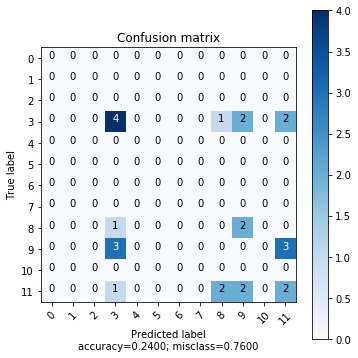

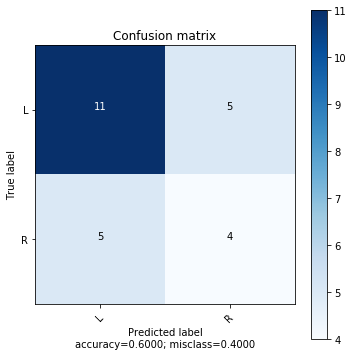

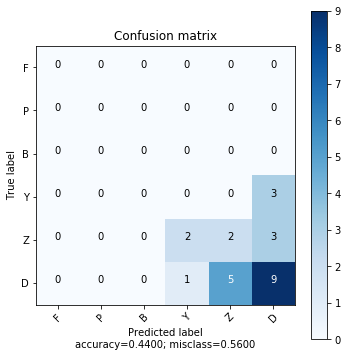

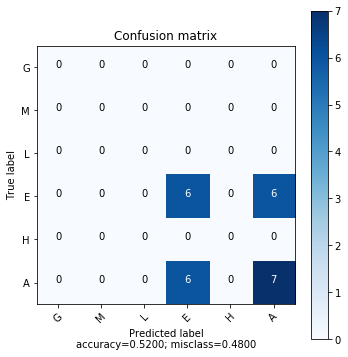

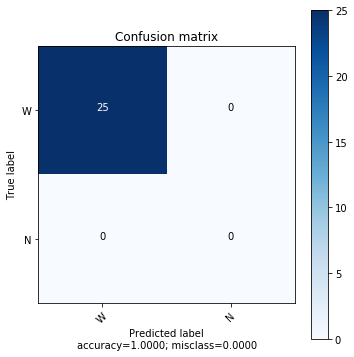

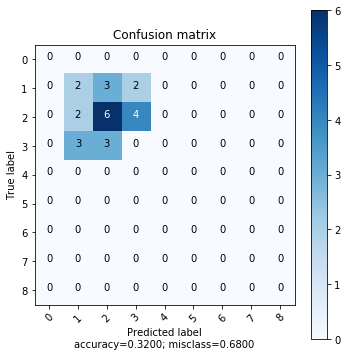

In [46]:
plot_cm_all_codes(train_true, train_pred, classes)

In [47]:
def cm_model_report(writer, folder, true, pred, classes):
    
    total_samples = len(true[0])
    start = 0
    m = []
    for i in range(len(classes)):
        
        # Accuracy Metrics
        prf = np.round(metrics.precision_recall_fscore_support(true[i], pred[i], average='weighted')[:-1],4)
        acc = np.round(metrics.accuracy_score(true[i], pred[i]),4)
        metric_list = ['Col'+str(i+2)]
        metric_list.extend(prf)
        metric_list.extend([acc])
        m.append(metric_list)
        
        #Confusion Matrix
        le = LabelEncoder().fit(classes[i])
        report = metrics.confusion_matrix(le.inverse_transform(true[i]), le.inverse_transform(pred[i]),labels = classes[i])
        df = pd.DataFrame(report, columns = classes[i], index = classes[i])
        df.to_excel(writer,sheet_name='CM_' + folder ,startrow=start , startcol=0)   
        start = start + len(classes[i]) + 2
    
    overall_acc = (pd.DataFrame(true) == pd.DataFrame(pred)).all().sum() / total_samples
    metrics_df = pd.DataFrame(m, columns = ['Col','Precision','Recall','F1','Accuracy'])
    metrics_df.to_excel(writer, sheet_name=folder, index = False)
    pd.DataFrame({'Accuracy' : [overall_acc],'Samples':[total_samples]}).to_excel(writer, sheet_name=folder, startrow = 8, index = False)
    
    return writer


In [48]:
writer = pd.ExcelWriter('/home/gungarg/Data/Affine/models/iterations/Model_Report.xlsx', engine='xlsxwriter')
writer = cm_model_report(writer, 'train', train_true, train_pred, classes)    
writer = cm_model_report(writer, 'val', val_true, val_pred, classes) 
writer = cm_model_report(writer, 'test', test_true, test_pred, classes) 
writer.save()

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
